In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
from tqdm.auto import tqdm
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('combined.csv')
df.head()

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,...,wind_gusts_10m_23,soil_temperature_0_to_7cm_23,soil_temperature_7_to_28cm_23,soil_temperature_28_to_100cm_23,soil_temperature_100_to_255cm_23,soil_moisture_0_to_7cm_23,soil_moisture_7_to_28cm_23,soil_moisture_28_to_100cm_23,soil_moisture_100_to_255cm_23,disaster_type
0,1941-05-20,51.0,29.55,26.80,28.243750,1.6,1.6,13.320000,21.599998,260.712220,...,15.119999,29.05,29.45,28.95,28.5,0.118,0.122,0.123,0.109,Storm
1,1947-10-20,1.0,28.35,24.60,26.481249,0.0,0.0,20.188908,29.160000,1.113367,...,20.519999,27.55,28.25,28.55,28.8,0.106,0.115,0.134,0.138,Storm
2,1958-10-19,51.0,29.55,24.10,26.766668,0.8,0.8,9.832680,15.119999,104.604450,...,9.000000,26.35,27.75,27.25,27.5,0.393,0.402,0.407,0.421,Storm
3,1960-10-08,63.0,27.65,25.70,26.587502,44.4,44.4,39.797504,55.079998,342.631530,...,55.079998,25.95,26.85,27.75,27.5,0.419,0.424,0.421,0.423,Storm
4,1960-10-29,61.0,28.90,23.25,25.699999,2.0,2.0,15.745627,20.880001,16.234982,...,14.759999,25.40,27.05,26.90,27.4,0.383,0.338,0.350,0.415,Storm


In [28]:
df_s = df[df['weather_code'] > 5.0]

Xm = df_s.loc[:, df.columns != 'disaster_type']
Y = df_s.loc[:, df.columns == 'disaster_type']

X = Xm.drop(columns='date')
print(X)


      weather_code  temperature_2m_max  temperature_2m_min  \
0             51.0               29.55               26.80   
2             51.0               29.55               24.10   
3             63.0               27.65               25.70   
4             61.0               28.90               23.25   
5             63.0               27.30               25.40   
...            ...                 ...                 ...   
1853          61.0               29.50               25.30   
1854          63.0               28.55               24.75   
1855          61.0               28.05               24.55   
1856          65.0               27.65               24.75   
1857          51.0               34.95               27.30   

      temperature_2m_mean  precipitation_sum   rain_sum  wind_speed_10m_max  \
0               28.243750           1.600000   1.600000           13.320000   
2               26.766668           0.800000   0.800000            9.832680   
3               26

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

We remove features, cause, uhhh.... there's a lot. Like 600 kinda lot

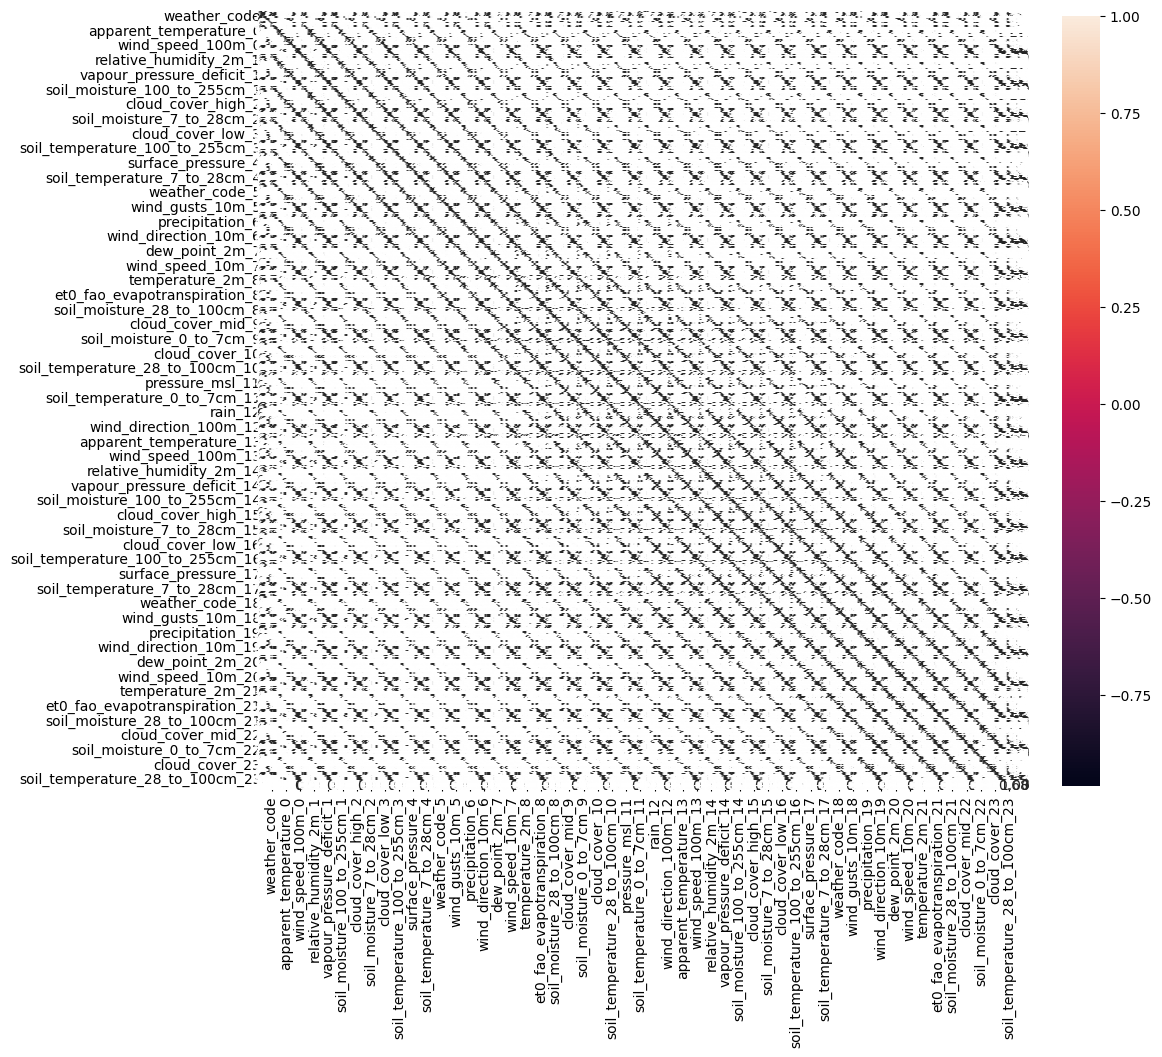

Reduced training set shape: (1236, 242)
Reduced testing set shape: (310, 242)


In [30]:
corr_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop the features
X_train_reduced = X_train.drop(columns=to_drop)
X_test_reduced = X_test.drop(columns=to_drop)

print(f"Reduced training set shape: {X_train_reduced.shape}")
print(f"Reduced testing set shape: {X_test_reduced.shape}")

In [32]:
Y['disaster_type'].unique()
print(y_train)

     disaster_type
568          Flood
1348         Flood
1002      Epidemic
1300      Epidemic
261          Flood
...            ...
1290      Epidemic
1562         Flood
1003      Epidemic
1770         Flood
1286      Epidemic

[1236 rows x 1 columns]


RandomForestClassifier to get feature importance

In [35]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_reduced, y_train)

RandomForestClassifier(random_state=42)

In [37]:
importances = clf.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train_reduced.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

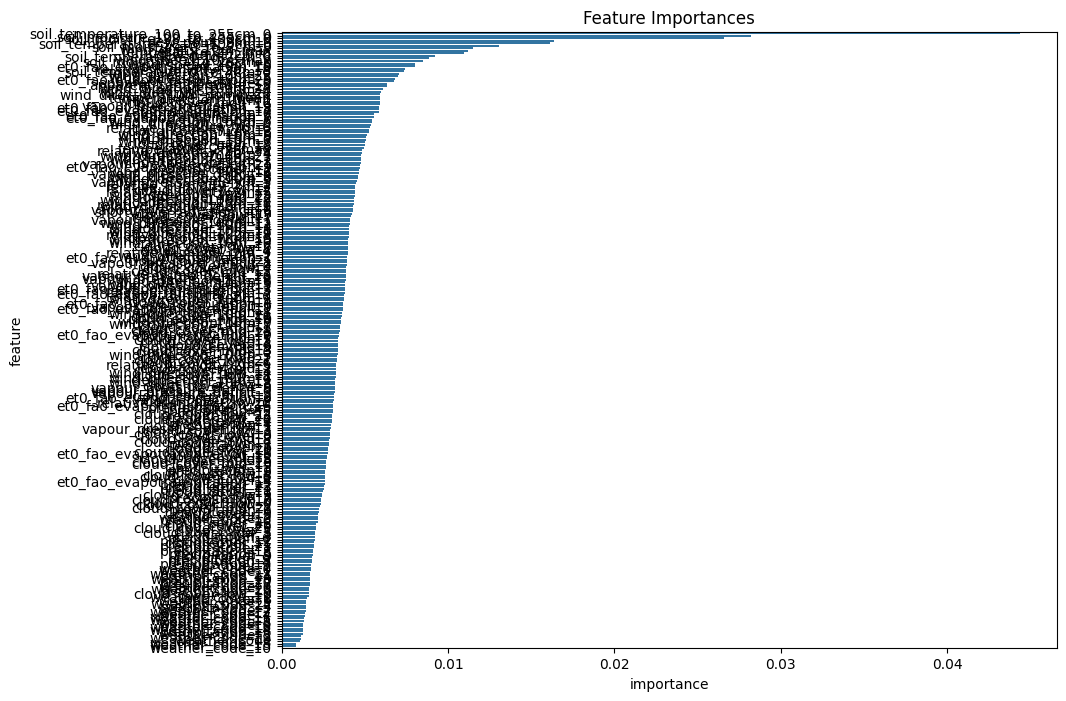

In [38]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

In [40]:
threshold = 0.01
selected_features = feature_importances[feature_importances['importance'] > threshold]['feature']

X_train_selected = X_train_reduced[selected_features]
X_test_selected = X_test_reduced[selected_features]
print(X_train_selected.shape)
print(X_test_selected.shape)

(1236, 9)
(310, 9)


In [48]:
clf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
clf_selected.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [49]:
y_pred = clf_selected.predict(X_test_selected)

In [50]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

Accuracy on test set: 0.80
